In [1]:
import numpy as np
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

from torch.utils.data import Dataset
import pickle

In [2]:
class Customcifar10(Dataset):
    def __init__(self, data_dir_list , transform=None, target_transform=None):

        def unpickle(file):
            with open(file, 'rb') as fo:
                dict = pickle.load(fo, encoding='bytes')
            return dict
        
        data_batch = unpickle(data_dir_list[0])
        images = data_batch[b'data']
        labels = data_batch[b'labels']
        for data_dir in data_dir_list[1:]:
            data_batch = unpickle(data_dir)
            images = np.append(images ,data_batch[b'data'], axis=0)
            labels = np.append(labels, data_batch[b'labels'], axis=0)

        images = images.reshape(len(images),3,32,32)
        self.images = images.transpose(0,2,3,1)
        self.labels = torch.LongTensor(labels)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

train_data_dir = [f'./cifar-10-python/data_batch_{i}' for i in range(1,6)]
test_data_dir = [f'./cifar-10-python/test_batch']

train_data = Customcifar10(train_data_dir , transform)
test_data = Customcifar10(test_data_dir, transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #, num_workers=2
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True) #, num_workers=2

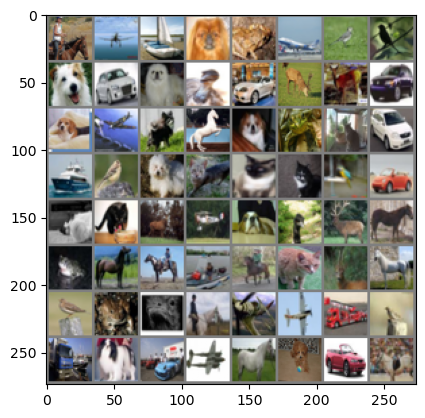

horse plane ship  dog   frog  plane bird  bird  dog   car   dog   bird  car   deer  deer  car   dog   plane dog   horse dog   frog  cat   car   ship  bird  dog   cat   cat   cat   bird  car   cat   cat   deer  plane dog   bird  deer  horse frog  horse horse ship  horse cat   deer  horse bird  frog  bird  horse plane plane truck bird  truck dog   car   plane horse dog   car   horse


In [4]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.195
[1,   400] loss: 0.189
[1,   600] loss: 0.184
[2,   200] loss: 0.175
[2,   400] loss: 0.170
[2,   600] loss: 0.167
Finished Training


In [13]:
PATH = './pth/cifar_net.pth'
torch.save(net.state_dict(), PATH)

# test

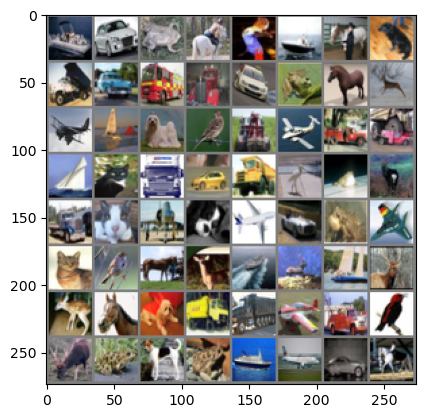

GroundTruth:  ship  car   frog  horse bird  ship  horse dog   truck car   truck truck car   frog  horse deer  plane ship  dog   bird  truck plane truck truck ship  cat   truck car   truck bird  frog  deer  truck cat   plane dog   plane car   frog  plane cat   bird  horse deer  ship  deer  ship  deer  deer  horse dog   truck truck plane truck bird  deer  frog  dog   frog  ship  plane car   horse


In [12]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [14]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  ship  car   ship  horse car   ship  horse horse truck car   truck cat   car   deer  horse bird  plane frog  cat   frog  truck ship  car   truck ship  car   car   frog  truck plane dog   bird  truck dog   truck horse plane car   frog  cat   horse deer  truck horse ship  ship  cat   deer  horse horse frog  frog  truck car   truck cat   horse frog  dog   frog  ship  ship  frog  horse


In [18]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 40 %


In [19]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 41.1 %
Accuracy for class: car   is 49.9 %
Accuracy for class: bird  is 9.6 %
Accuracy for class: cat   is 14.9 %
Accuracy for class: deer  is 35.1 %
Accuracy for class: dog   is 32.1 %
Accuracy for class: frog  is 59.0 %
Accuracy for class: horse is 55.5 %
Accuracy for class: ship  is 48.1 %
Accuracy for class: truck is 57.2 %
